In [8]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np
import os
import PIL

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.6.2
Hub version: 0.12.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is NOT AVAILABLE


In [11]:
module_selection = ("mobilenet_v2_100_224", 224) 
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32 

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


#  Setup dataset

In [12]:
# data_dir = tf.keras.utils.get_file(
#     'garbageclassification',
#     'http://d668966ed0a6.ngrok.io/garbageclassification.tgz',
#     untar=True)

In [13]:
# data_dir2 is just for showing some samples 
import pathlib
data_dir = "litter_sample_dataset"
data_dir2 = pathlib.Path(data_dir)
image_count = len(list(data_dir2.glob('*/*.jpg')))
print(image_count)

3661


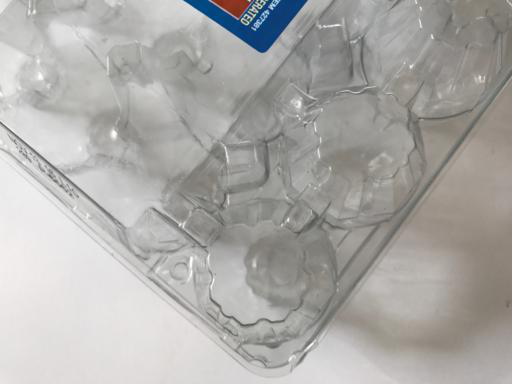

In [14]:
plastic = list(data_dir2.glob('plastic/*'))
PIL.Image.open(str(plastic[0]))

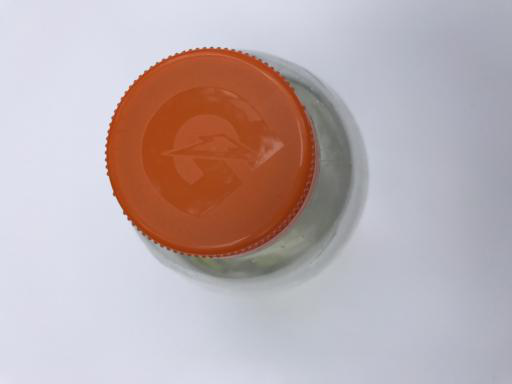

In [15]:
PIL.Image.open(str(plastic[2]))

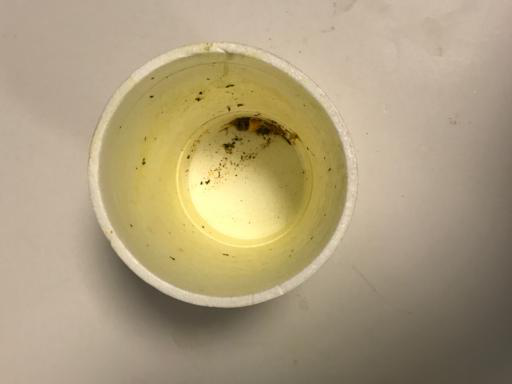

In [16]:
wrapper = list(data_dir2.glob('wrapper/*'))
PIL.Image.open(str(wrapper[0]))

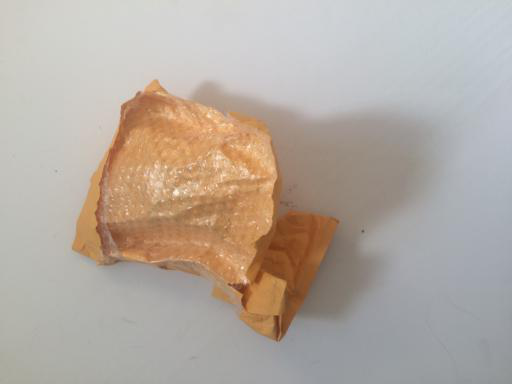

In [17]:
PIL.Image.open(str(wrapper[5]))

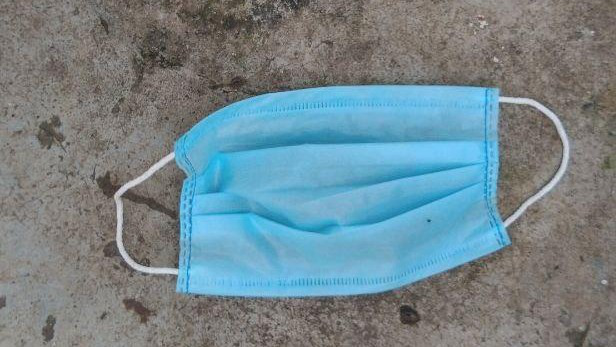

In [18]:
mask = list(data_dir2.glob('mask/*'))
PIL.Image.open(str(mask[0]))

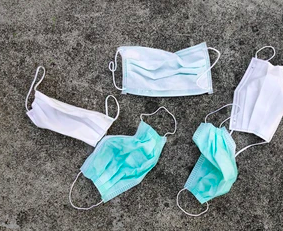

In [19]:
PIL.Image.open(str(mask[6]))

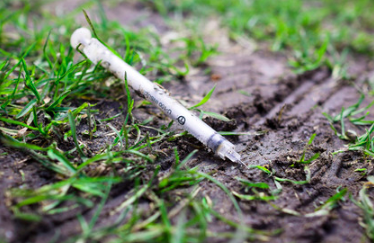

In [20]:
syringe = list(data_dir2.glob('syringe/*'))
PIL.Image.open(str(syringe[2]))

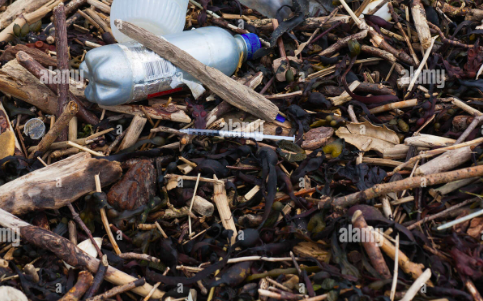

In [21]:
syringe = list(data_dir2.glob('syringe/*'))
PIL.Image.open(str(syringe[8]))

In [22]:
datagen_kwargs = dict(rescale=1./255, validation_split=.020)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, 
                      batch_size=BATCH_SIZE,
                      interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)

valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", 
    shuffle=False, **dataflow_kwargs)

Found 72 images belonging to 13 classes.


In [23]:
do_data_augmentation = False 
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                                        rotation_range=40,
                                                        horizontal_flip=True,
                                                        width_shift_range=0.2, 
                                                        height_shift_range=0.2,
                                                        shear_range=0.2, 
                                                        zoom_range=0.2,
                                                        **datagen_kwargs)
else:
  train_datagen = valid_datagen

train_generator = train_datagen.flow_from_directory(
                                                    data_dir, 
                                                    subset="training", 
                                                    shuffle=True, 
                                                    **dataflow_kwargs)

Found 3704 images belonging to 13 classes.


In [24]:
class_names = train_generator.class_indices.items()
print(class_names)

dict_items([('cardboard', 0), ('garbage', 1), ('glass', 2), ('leaf', 3), ('mask', 4), ('metal', 5), ('paper', 6), ('plastic', 7), ('polythenebag', 8), ('recyclable', 9), ('syringe', 10), ('test', 11), ('wrapper', 12)])


# visulaize the data 

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

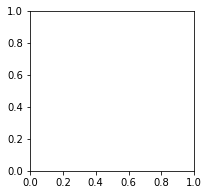

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_generator:
  print(labels)
  print(images)
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Charts
import seaborn as sns

# ML, statistics
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

sns.countplot(x='catagories', data = list(train_generator))


In [ ]:
data_dir2.value_counts().plot(kind='bar')
plt.title('Labels counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


In [ ]:
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

# Defining the model

In [ ]:
do_fine_tuning = False 

In [ ]:
import tensorflow as tf
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

# Training the model

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [ ]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size

hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data = valid_generator,
    validation_steps = validation_steps).history

In [ ]:
# confusion matrix creates ccrashes the entore session , todo : find out why ?
#conf_mat = confusion_matrix(np.argmax(train_generator,axis = 1),model.predict(train_generator))
# print(conf_mat)

In [ ]:
plt.figure()
plt.ylabel("Loss ")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"], lable="training loss")
plt.plot(hist["val_loss"], label = "validation loss")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"], title="training accuracy")
plt.plot(hist["val_accuracy"], title="validation accuracy")
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

In [ ]:
def get_class_string_from_index(index):
   for class_string, class_index in valid_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(valid_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

In [ ]:
x, y = valid_generator[1]
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

In [ ]:
litter_url = "http://d668966ed0a6.ngrok.io/bottle1.jpg"
litter_path = tf.keras.utils.get_file('plastic', origin=litter_url)

img = tf.keras.preprocessing.image.load_img(
    litter_path, target_size=(224, 224)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(predictions)

print(list(class_names))
print(score)

print( "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(list(class_names)[np.argmax(score)], 100 * np.max(score)) )

# Save the Model 

In [ ]:
saved_model_path = "/tmp/saved_garbageclassification_model"
tf.saved_model.save(model, saved_model_path)